# Non-ALS Domains

In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%load_ext autoreload
%autoreload 2

In [2]:
import joblib
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Pre-process datasets

In [3]:
ppmi_path = '/Users/divyar/Documents/Grad - Divya/Research/ALS_integration/data/raw/clinical/PPMI/PPMI_021022/'
adni_path = '/Users/divyar/Documents/Grad - Divya/Research/ALS_integration/data/raw/clinical/ADNI/'

In [4]:
def process_data_nonals(data, curfeat, subj_col, delta_col):
    """Convert pandas dataframe to data dictionary for MoGP input, EXCLUDING adding onset anchor datapoint"""
    data_dict = {}

    X_df = data.pivot(index=subj_col, columns='Visit_Number', values=delta_col)
    Y_df = data.pivot(index=subj_col, columns='Visit_Number', values=curfeat)
    assert (X_df.index == Y_df.index).all(), 'X and Y df indexes do not match'

    SI = list(X_df.index)
    Y_mean = Y_df.stack().mean()
    Y_std = Y_df.stack().std()

#     # Add onset anchor value at symptom onset
#     X_df.insert(0, 0.0, 0.)
#     Y_df.insert(0, 0.0, max_feat * np.ones(data[subj_col].nunique()))

    data_dict['SI'] = SI
    data_dict['XA'] = X_df.to_numpy()
    data_dict['YA'] = Y_df.to_numpy()
    data_dict['Y_mean'] = Y_mean
    data_dict['Y_std'] = Y_std
    return data_dict

In [5]:
# ADNI:

df_ad = pd.read_csv(adni_path+'/Study Info/ADNIMERGE.csv')
df_diag = pd.read_csv(adni_path + '/Diagnosis/DXSUM_PDXCONV_ADNIALL.csv')
df_onset = pd.read_csv(adni_path + '/PTDEMOG.csv')

df_ad_sub = df_ad.dropna(subset=['ADAS13','Years_bl']).copy()

# both minimum 3 visits and has AD diagnosis (exclude MCI/ HC)
min3lis = df_ad_sub.groupby('PTID').size()[df_ad_sub.groupby('PTID').size()>=3].index
ad_diaglis = df_diag[df_diag['DXCURREN']==3]['PTID']

df_ad_min3 = df_ad_sub[df_ad_sub['PTID'].isin(set(min3lis)&set(ad_diaglis))].copy()
df_ad_min3.dropna(subset=['Years_bl', 'PTID', 'ADAS13'], inplace=True)


df_ad_min3.sort_values(by=['PTID','Years_bl'], inplace=True)

/Users/divyar/Documents/Grad - Divya/Research/mogp/mogpvenv-3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (19,20,21,104,105,106) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
# Add Visit Number Column
df_ad_min3['Visit_Number']=df_ad_min3.groupby('PTID')['Years_bl'].rank("dense")

# Take inverse of scores to suit monotonically declining constraints
df_ad_min3['neg-ADAS13']=-df_ad_min3['ADAS13']

In [7]:
adni_dict = process_data_nonals(df_ad_min3, curfeat='neg-ADAS13', subj_col='PTID',  delta_col='Years_bl')

In [8]:
# PPMI:

# Load Files
patient_status = pd.read_excel(ppmi_path + 'Consensus_Committee_Analytic_Datasets_28OCT21.xlsx', sheet_name='PD')
mds = pd.read_csv(ppmi_path + 'MDS_UPDRS_Part_III.csv')
#get diagnosis history, SXDT = date of symptom, PDDXDT = date of Parkinson's disease diagnosis
patient_diagnosis = pd.read_csv(ppmi_path + 'PD_Diagnosis_History.csv')

#Filter for PD cohort and OFF medication (note that NaN is prior to initation of medications,
#all patients were required not to have started medication at enrollment)
pd_ids = patient_status[(patient_status.Subgroup=='Sporadic') & (patient_status.Comments.isnull())].PATNO.unique()
pd_mds = mds[np.isin(mds.PATNO, pd_ids) & (mds.PDSTATE != 'ON')][['PATNO', 'EVENT_ID', 'INFODT', 'NP3TOT', 'PDSTATE']]

pd_pd = patient_diagnosis[np.isin(patient_diagnosis.PATNO, pd_ids) & (patient_diagnosis.EVENT_ID == 'SC')]
df = pd_mds.merge(pd_pd[['PATNO', 'SXDT', 'PDDXDT']],  how='left', on='PATNO')

# convert dates to usable numbers
ix_as_num = []
dx_as_num = []
sx_as_num = []

infodt = df.INFODT.str.split('/')
sxdt = df.SXDT.str.split('/')
pddt = df.PDDXDT.str.split('/')

for i in range(len(df)):
    ix_as_num.append(float(infodt[i][0])/12. + float(infodt[i][1]))
    dx_as_num.append(float(pddt[i][0])/12. + float(pddt[i][1]))
    
    try:
        sx_as_num.append(float(sxdt[i][0])/12. + float(sxdt[i][1]))
    except:
        sx_as_num.append(np.NaN)
        
df['Visit_date'] = ix_as_num
df['Diagnosis_date'] = dx_as_num
df['Symptom_date'] = sx_as_num

df['Time_since_diagnosis'] = df['Visit_date'] - df['Diagnosis_date']
df['Time_since_onset'] = df['Visit_date'] - df['Symptom_date']

# df.sort_values(by=['PATNO', 'Time_since_onset'], inplace=True)

/Users/divyar/Documents/Grad - Divya/Research/mogp/mogpvenv-3.7.3/lib/python3.7/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/Users/divyar/Documents/Grad - Divya/Research/mogp/mogpvenv-3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (10,11,17,18,19,20,21,32) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
min3_ppmi=df.groupby('PATNO').size()[df.groupby('PATNO').size()>=3].index
onset_10y=df.groupby('PATNO')['Time_since_onset'].min()[df.groupby('PATNO')['Time_since_onset'].min()<10].index
df_ppmi_min3 = df[df['PATNO'].isin(set(min3_ppmi)&set(onset_10y))].copy()

df_ppmi_min3.dropna(subset=['Time_since_onset', 'PATNO', 'NP3TOT'], inplace=True)

# # Clean duplicated visits
df_ppmi_min3 = df_ppmi_min3.groupby(['PATNO', 'Time_since_onset']).mean().reset_index()

df_ppmi_min3.sort_values(by=['PATNO', 'Time_since_onset'], inplace=True)
df_ppmi_min3['Visit_Number']=df_ppmi_min3.groupby('PATNO')['Time_since_onset'].rank("dense")

df_ppmi_min3['neg-NP3TOT']=-df_ppmi_min3['NP3TOT']


In [10]:
ppmi_dict = process_data_nonals(df_ppmi_min3, curfeat='neg-NP3TOT', subj_col='PATNO',  delta_col='Time_since_onset')

In [13]:
save_path = 'data/model_data/5_nonals_domains/'
joblib.dump(ppmi_dict, save_path + 'data_ppmi_min3_updrs.pkl')
joblib.dump(adni_dict, save_path + 'data_adni_min3_adas13.pkl')

['data/model_data/5_nonals_domains/data_ppmi_min3_updrs.pkl']

['data/model_data/5_nonals_domains/data_adni_min3_adas13.pkl']

# Plot datasets



No. pats: 331


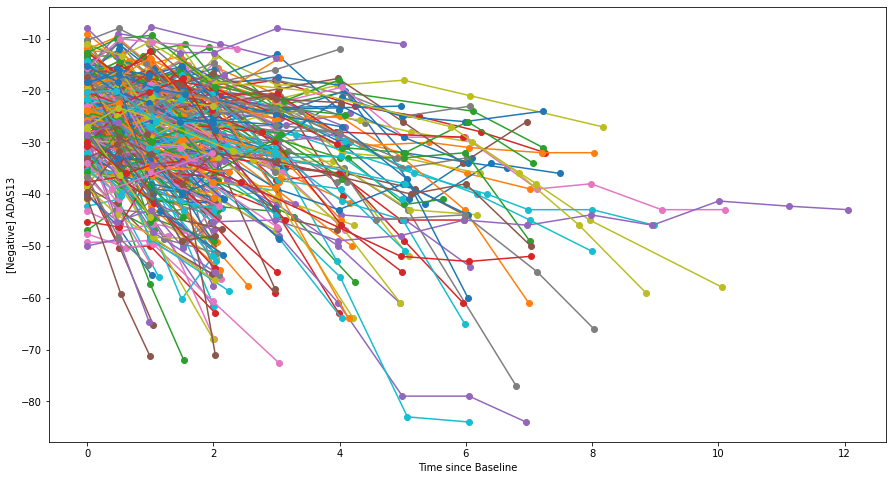

In [11]:
cur_cat = 'neg-ADAS13'
fig, ax = plt.subplots(figsize=(15,8))

print('No. pats:',  df_ad_min3['PTID'].nunique())
for pat in df_ad_min3['PTID'].unique():
#     pat_onset = df_clin.loc[pat]['onsetdt']
    df_slice = df_ad_min3[df_ad_min3['PTID']==pat]
    _ = ax.plot((df_slice['Years_bl']), df_slice[cur_cat], '-o')
    
_ = ax.set_xlabel('Time since Baseline')
_ = ax.set_ylabel('[Negative] ADAS13')
# _ = ax.set_xlim([0,10])

No. pats: 397


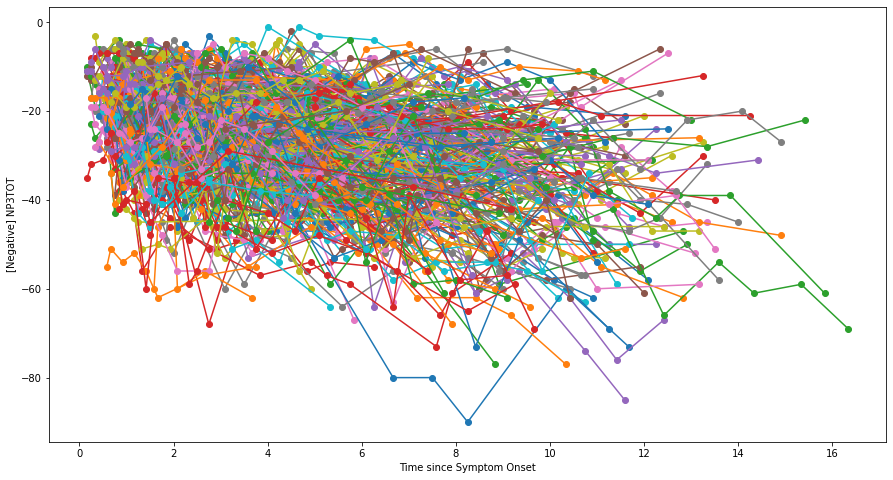

In [12]:
cur_cat = 'neg-NP3TOT'
fig, ax = plt.subplots(figsize=(15,8))

print('No. pats:',  df_ppmi_min3['PATNO'].nunique())
for pat in df_ppmi_min3['PATNO'].unique():
#     pat_onset = df_clin.loc[pat]['onsetdt']
    df_slice = df_ppmi_min3[df_ppmi_min3['PATNO']==pat]
    _ = ax.plot((df_slice['Time_since_onset']), df_slice[cur_cat], '-o')
    
_ = ax.set_xlabel('Time since Symptom Onset')
_ = ax.set_ylabel('[Negative] NP3TOT')
# _ = ax.set_xlim([0,10])